In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from mopet import mopet

from synchronization import plots
from synchronization import runner
from synchronization import analysis
from synchronization import processing
from synchronization import constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise can lead to synchronization across two networks

## Model Configuration

The default parameters set the model in a state where high noise strength (13.0) synchronized the otherwise desynchronized networks 1 and 2.

In [72]:
params = {
  "runtime": 1000.0,

  "J_itoi": 5.0,
  "J_etoe": 0.6,
  "J_etoi": 3.2,
  "J_itoe": 7.0,

  "ou_enabled": [False, False],

  "poisson_enabled": [True, True],
  "poisson_variance": 13.0,
  "poisson_p": 0.7,
  "poisson_size": 800,
  "poisson_mean_input": 600,

   "J_ppee": 0.6,
   "J_ppei": 0.6,

   "const_delay": 0.2,
   "N_pop": 2
}

In [ ]:
model = runner.run(modified_params=params, file_name="meng-replication")

Initializing net ...
Net 1 - poisson rate 27692.30769230769 - single neuron 34.61538461538461
Poisson strength: 0.021666666666666667
Net 2 - rate for single neuron 24.230769230769226
Initialization time: 0.4931049346923828s
==== Running Network ... ====


In [77]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("meng-replication")

## Model Visualization

## Power Spectral Density

We can see here peak activity in 40-60 Hz of both networks. Confirms gamma band activity.

As we have uncorrelated noise as input which leads to irregular firing, the frequency band is wide.

However density/bandpower of excitatory group is significantly lower than inhibitory group. Can this be explained by the sparse firing of E cells?
As only a fraction of E cells participate in each cycle of the PING rhythm compared to the regular firing of the inhibitory group.

(<Figure size 576x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f84b110>)

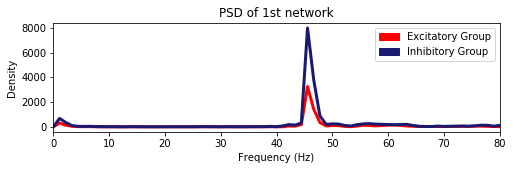

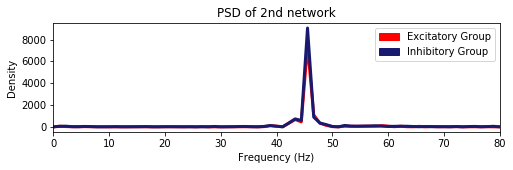

In [80]:
plots.psd(model, title="PSD of 1st network", population=1, fig_size=(8, 2), xlim=80)
plots.psd(model, title="PSD of 2nd network", population=2, fig_size=(8, 2), xlim=80)

## Local Field Potentials

We have an "artifact" at the beginning where all neurons spike immediately.
Otherwise voltage distribution is narrow, all neurons in range of -57-49mV.

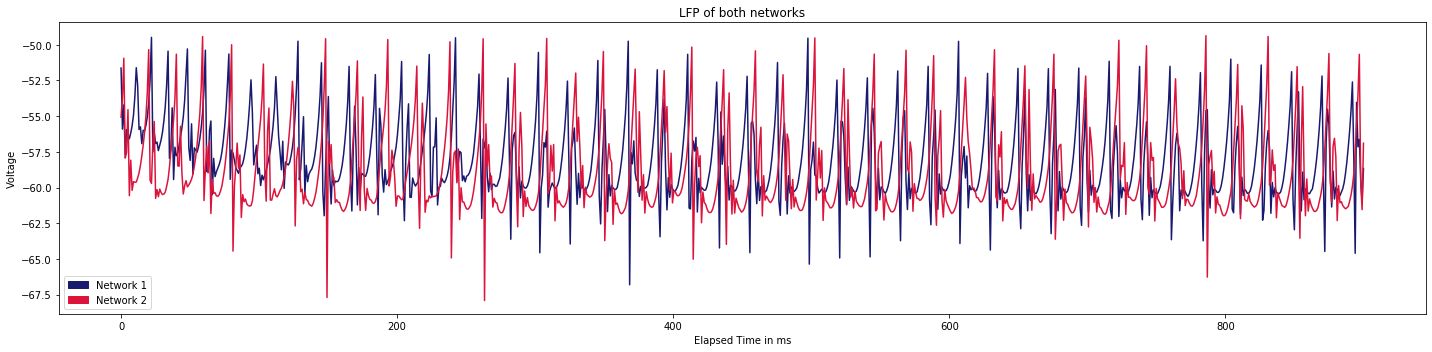

In [25]:
plots.lfp_nets(model, skip=100)

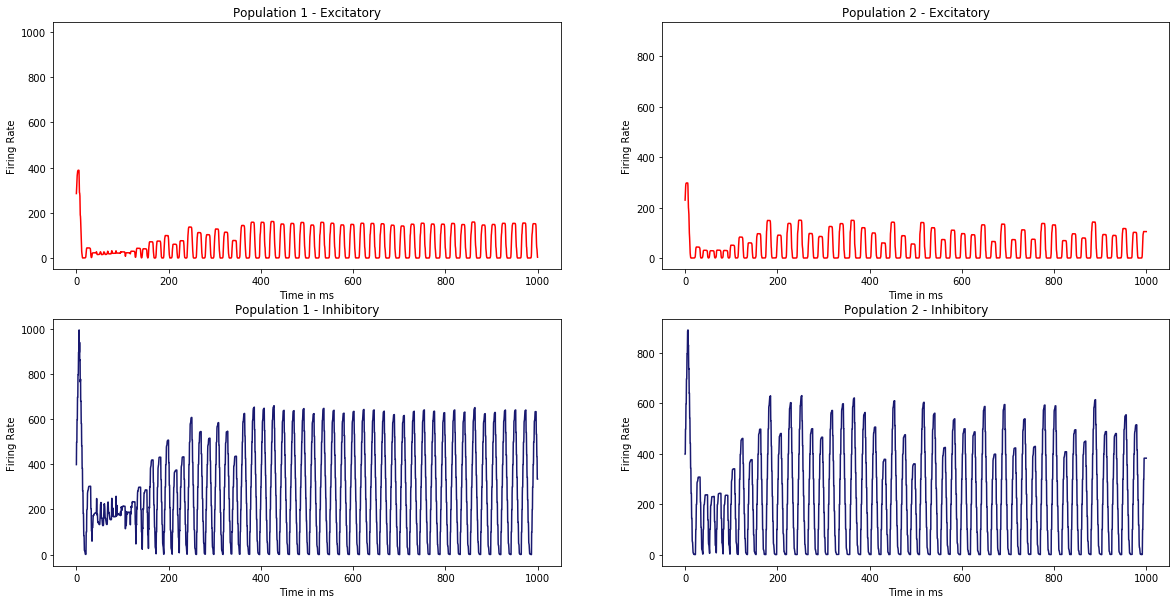

In [26]:
# plots.raster(title="Raster of 1st network", model=model, fig_size=(30, 20), save=True, key="stoch_weak_PING")
# plots.raster(title="Raster of 2nd network", model=model, population=2, x_right=500)
plots.population_rates(model)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d85fa10>)

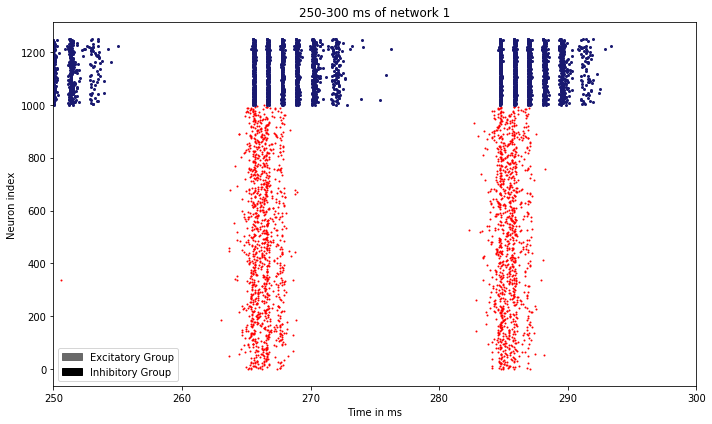

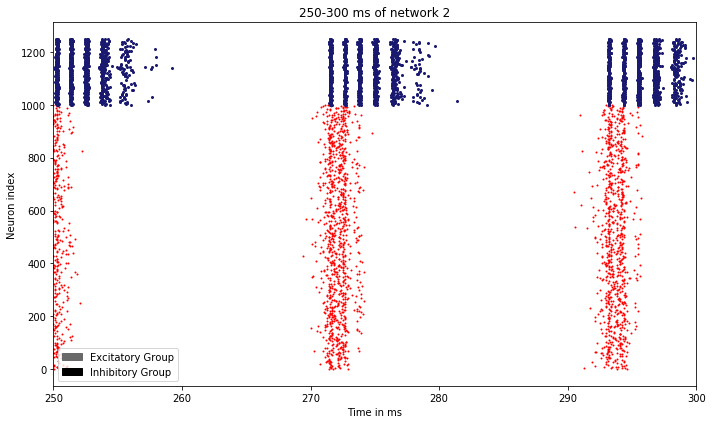

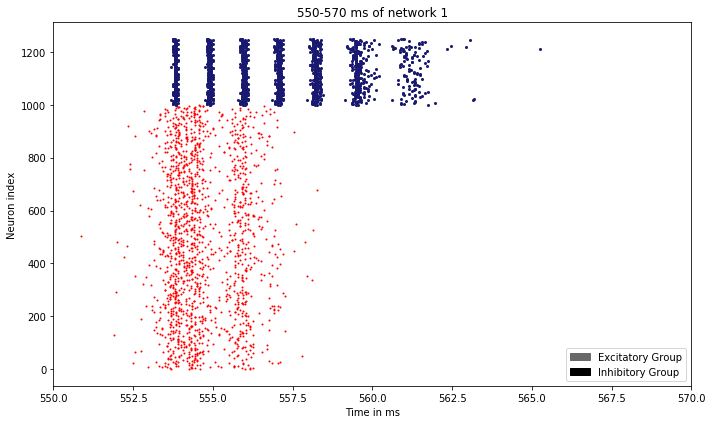

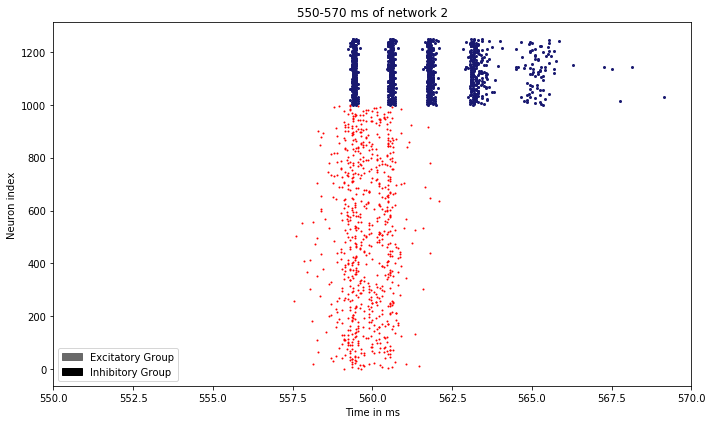

In [27]:
# plots.raster(title="200-400 ms of 1st network", model=model, x_left=200, x_right=400)
# plots.raster(title="200-400 ms of 2nd network", model=model, x_left=200, x_right=400, population=2)

plots.raster(title="250-300 ms of network 1", model=model, x_left=250, x_right=300)
plots.raster(title="250-300 ms of network 2", model=model, x_left=250, x_right=300, population=2)

plots.raster(title="550-570 ms of network 1", model=model, x_left=550, x_right=570)
plots.raster(title="550-570 ms of network 2", model=model, x_left=550, x_right=570, population=2)

## Spike Variability of Excitatory Neurons

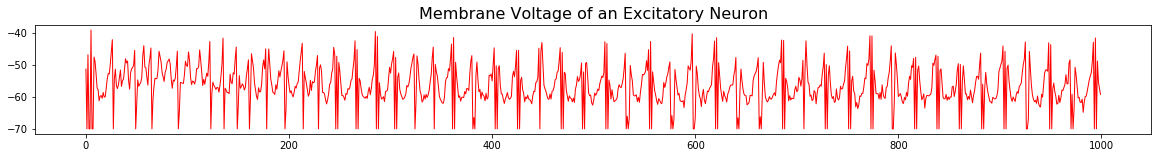

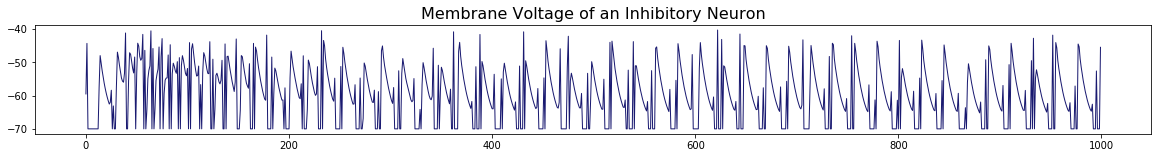

In [28]:
v = model["v_all_neurons_e"]
t = model["t_all_neurons_e"]

plt.figure(figsize=(20, 2))
plt.title("Membrane Voltage of an Excitatory Neuron", fontsize=16)
plt.plot(t, v[0], c=plots.c_exc, linewidth=1.0)

v = model["v_all_neurons_i1"]
t = model["t_all_neurons_i1"]

plt.figure(figsize=(20, 2))
plt.title("Membrane Voltage of an Inhibitory Neuron", fontsize=16)
plt.plot(t, v[0], c=plots.c_inh, linewidth=1.0)

## Synchronization Analysis

Meng et al. compute two different order parameters: The global order parameter and the local order parameter.

Considerations:
* Meng et al. mention that in the IF-model the voltage trace $V(t)$ does not include the action potential itself, therefore they add a spike of $45 mV$ manually.
Do we have the same case in our model?
* Meng et al. used only inhibitory connections and oscillations in the gamma band are caused by the ING mechanism. For a perfectly synchronized ING-rhythm we expect **all** neurons to fire in total synchrony. However, in PING we have an interplay between pyramidal neurons (excitatory) and interneurons (inhibitory). Thus, in a state of perfect synchrony we expect a small phase difference between the excitatory group and the ihibitory group. Considering this, the order parameter would never reach optimal value as we always have phase differences between the two groups. However, we could alter the order parameter by computing average phase synchronization for excitatory and inhibitory group seprately and then again use the average of both groups as measure for within-synchronization in the network.


### Across Network Phase Synchronization

Global Order Parameter value of: 0.7199315923879928


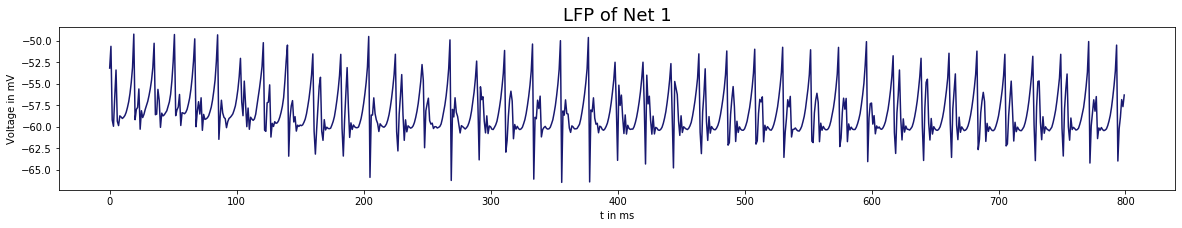

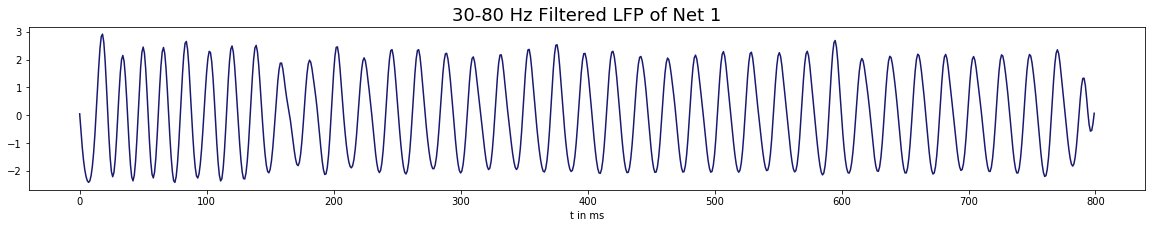

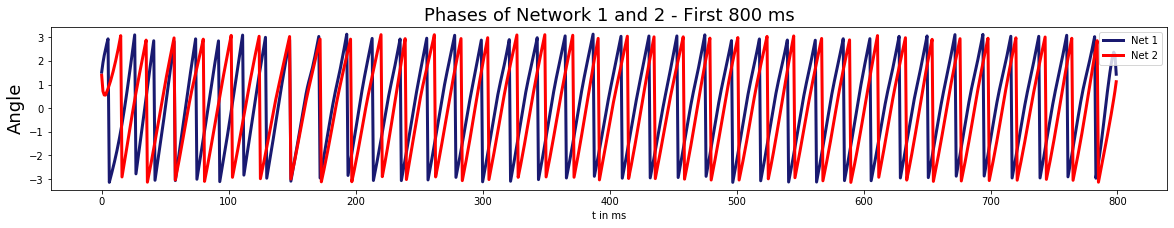

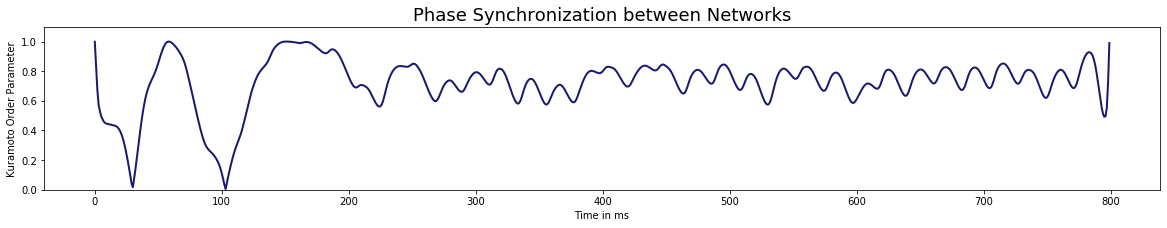

In [84]:
lfp1, lfp2 = processing.lfp_nets(model, skip=200)

f_lfp1, f_lfp2 = (processing.filter(lfp1, lowcut=30, highcut=80), processing.filter(lfp2, lowcut=30, highcut=80))

global_order_parameter = processing.order_parameter_over_time((f_lfp1, f_lfp2))

total_value = np.mean(global_order_parameter)
print(f"Global Order Parameter value of: {total_value}")

plt.figure(figsize=(20, 3))
plt.title("LFP of Net 1", fontsize=18)
plt.plot(lfp1, c=plots.c_inh)
plt.xlabel("t in ms")
plt.ylabel("Voltage in mV")

plt.figure(figsize=(20, 3))
plt.title("30-80 Hz Filtered LFP of Net 1", fontsize=18)
plt.xlabel("t in ms")
plt.plot(f_lfp1, c=plots.c_inh)

plt.figure(figsize=(20, 3))
plt.title("Phases of Network 1 and 2 - First 800 ms", fontsize=18)
plt.xlabel("t in ms")
plt.ylabel("Angle", fontsize=18)
plt.plot(processing.phase(f_lfp1[:800]), linewidth=3.0, c=plots.c_inh)
plt.plot(processing.phase(f_lfp2[:800]), linewidth=3.0, c=plots.c_exc)
plt.legend(["Net 1", "Net 2"])

plt.figure(figsize=(20, 3))
plt.title(f"Phase Synchronization between Networks", fontsize=18)
plt.xlabel("Time in ms")
plt.ylim(0, 1.1)
plt.ylabel("Kuramoto Order Parameter")
plt.plot(global_order_parameter, linewidth=2.0, c=plots.c_inh)

### Within Phase Synchronization

In [53]:
print("Computing within synchronization for network 1 and 2")

neurons_net_1 = np.vstack((
    model['v_all_neurons_e'],
    model['v_all_neurons_i1']
))[:,200:]

neurons_net_2 = np.vstack((
    model['v_all_neurons_e2'],
    model['v_all_neurons_i2']
))[:,200:]

f_neurons_net_1 = [processing.filter(n, lowcut=30, highcut=80) for n in neurons_net_1]
f_neurons_net_2 = [processing.filter(n, lowcut=30, highcut=80) for n in neurons_net_2]

f_plv_net_1 = processing.order_parameter_over_time(f_neurons_net_1)
f_plv_net_1_i = processing.order_parameter_over_time(f_neurons_net_1[1000:])
f_plv_net_1_e = processing.order_parameter_over_time(f_neurons_net_1[:1000])

f_plv_net_2 = processing.order_parameter_over_time(f_neurons_net_2)
# as comparison
plv_net_2 = processing.order_parameter_over_time(neurons_net_2)

print("Within Synchronization of Network 1", np.mean(f_plv_net_1))
print("Within Synchronization of Network 2", np.mean(f_plv_net_2))

Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.5711352840411741
Within Synchronization of Network 2 0.5934534892477077


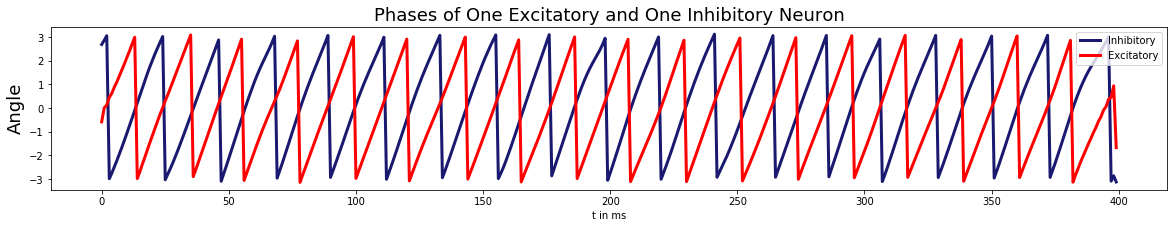

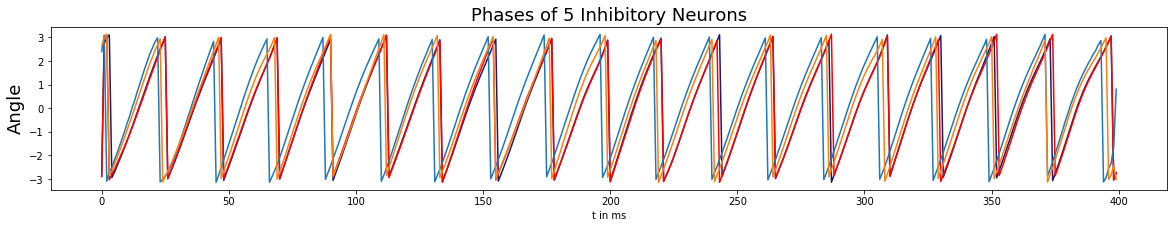

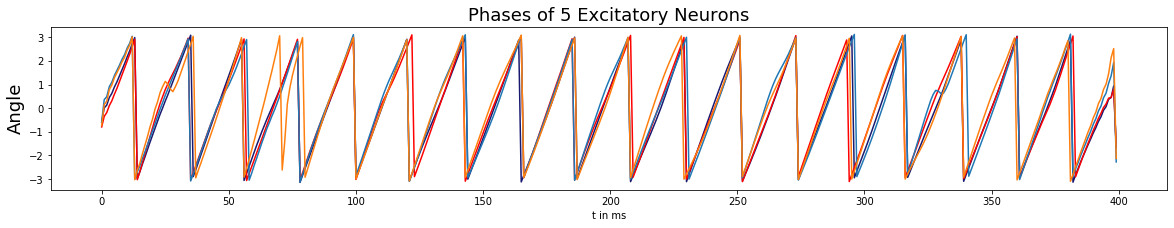

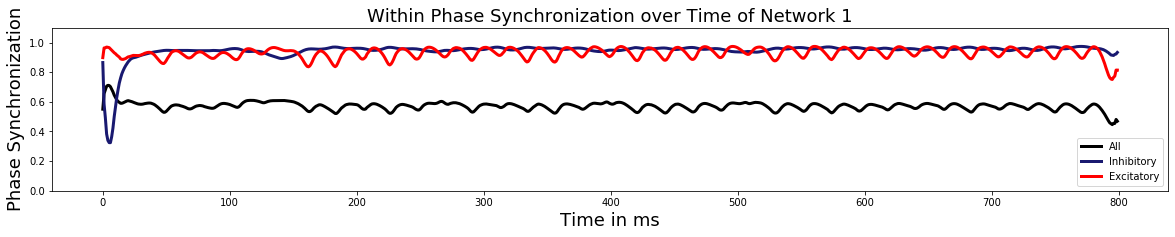

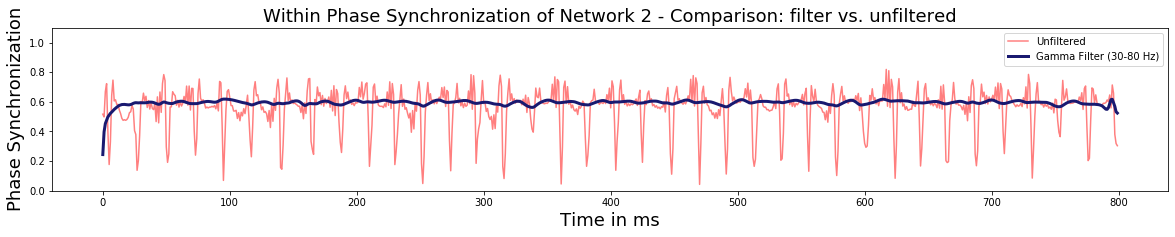

In [83]:
skip = 200
duration = 600

plt.figure(figsize=(20, 3))
plt.title("Phases of One Excitatory and One Inhibitory Neuron", fontsize=18)
plt.xlabel("t in ms")
plt.ylabel("Angle", fontsize=18)
plt.plot(processing.phase(f_neurons_net_1[1001][skip:duration]), linewidth=3.0, c=plots.c_inh)
plt.plot(processing.phase(f_neurons_net_1[1][skip:duration]), linewidth=3.0, c=plots.c_exc)
plt.legend(["Inhibitory", "Excitatory"])

plt.figure(figsize=(20, 3))
plt.title("Phases of 5 Inhibitory Neurons", fontsize=18)
plt.xlabel("t in ms")
plt.ylabel("Angle", fontsize=18)
plt.plot(processing.phase(f_neurons_net_1[1002][skip:duration]), linewidth=1.5, c=plots.c_inh)
plt.plot(processing.phase(f_neurons_net_1[1003][skip:duration]), linewidth=1.5, c=plots.c_exc)
plt.plot(processing.phase(f_neurons_net_1[1004][skip:duration]), linewidth=1.5)
plt.plot(processing.phase(f_neurons_net_1[1005][skip:duration]), linewidth=1.5)

plt.figure(figsize=(20, 3))
plt.title("Phases of 5 Excitatory Neurons", fontsize=18)
plt.xlabel("t in ms")
plt.ylabel("Angle", fontsize=18)
plt.plot(processing.phase(f_neurons_net_1[1][skip:duration]), linewidth=1.5, c=plots.c_inh)
plt.plot(processing.phase(f_neurons_net_1[2][skip:duration]), linewidth=1.5, c=plots.c_exc)
plt.plot(processing.phase(f_neurons_net_1[3][skip:duration]), linewidth=1.5)
plt.plot(processing.phase(f_neurons_net_1[4][skip:duration]), linewidth=1.5)

plt.figure(figsize=(20, 3))
plt.title(f"Within Phase Synchronization over Time of Network 1", fontsize=18)
plt.xlabel("Time in ms", fontsize=18)
plt.ylim(0, 1.1)
plt.ylabel("Phase Synchronization", fontsize=18)
plt.plot(f_plv_net_1, linewidth=3.0, c="black")
plt.plot(f_plv_net_1_i, linewidth=3.0, c=plots.c_inh)
plt.plot(f_plv_net_1_e, linewidth=3.0, c=plots.c_exc)
plt.legend(["All", "Inhibitory", "Excitatory"])

plt.figure(figsize=(20, 3))
plt.title(f"Within Phase Synchronization of Network 2 - Comparison: filter vs. unfiltered", fontsize=18)
plt.xlabel("Time in ms", fontsize=18)
plt.ylim(0, 1.1)
plt.ylabel("Phase Synchronization", fontsize=18)
plt.plot(plv_net_2, alpha=0.5, c=plots.c_exc)
plt.plot(f_plv_net_2, linewidth=3.0, c=plots.c_inh)
plt.legend(["Unfiltered", "Gamma Filter (30-80 Hz)"])

NameError: name 'avg' is not defined

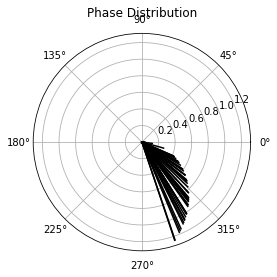

In [32]:
# TODO: fix this
# We want to plot here the average phase angle vectors of each neuron on the polar axis

phases = processing.phase(f_neurons_net_1)

plt.axes(polar=True)
plt.title("Phase Distribution")

for angle in phases[:50]:
    plt.plot((0, angle[10]), (0, np.abs(angle[10])), c="black")

# plot the average phase vector
# length of vector expresses the synchronization, [0-1].
plt.plot((0, avg[10]), (0, phi[10]), c='red')
plt.show()